<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Final/Grid_Test_Knock_Out_Call_1stock_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(0.5, 1.0, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)

print(S_range)
print(K_range)
print(B_range)
print(sigma_range)
print(r_range)

[0.75       0.8055556  0.86111116 0.9166666  0.97222227 1.0277778
 1.0833334  1.138889   1.1944445  1.25      ]
[0.75       0.82142854 0.89285713 0.9642857  1.0357143  1.1071429
 1.1785713  1.25      ]
[0.5        0.5714286  0.6428572  0.71428573 0.78571427 0.85714287
 0.92857146 1.        ]
[0.15       0.25       0.35000002 0.45      ]
[0.01  0.025 0.04 ]


In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(0.5, 1.0, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []
count = 0

for S in S_range:
  for K in K_range:
    for B in B_range:
      for r in r_range:
        for sigma in sigma_range:    

          initial_stocks = jnp.array([S]*numstocks) # must be float
          r_tmp = jnp.array([r]*numstocks)
          drift = r_tmp
          cov = jnp.identity(numstocks)*sigma*sigma

          Knock_Out_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T)
          Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T)
          call.append([T, K, B, S, sigma, r, r, Knock_Out_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
          
          count += 1
          print(count)

In [ ]:
Thedataset = pd.DataFrame(call)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,0.5,0.75,0.15,0.010,0.010,0.048392188,0.556177
1,1.0,0.75,0.5,0.75,0.25,0.010,0.010,0.07790985,0.564888
2,1.0,0.75,0.5,0.75,0.35,0.010,0.010,0.10672783,0.573440
3,1.0,0.75,0.5,0.75,0.45,0.010,0.010,0.1332959,0.571065
4,1.0,0.75,0.5,0.75,0.15,0.025,0.025,0.054101802,0.595272
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.0,1.25,0.45,0.025,0.025,0.20006092,0.472318
7676,1.0,1.25,1.0,1.25,0.15,0.040,0.040,0.10021045,0.632276
7677,1.0,1.25,1.0,1.25,0.25,0.040,0.040,0.14452648,0.584406
7678,1.0,1.25,1.0,1.25,0.35,0.040,0.040,0.180067,0.530899


In [ ]:
# save to csv
Thedataset.to_csv('Knock_Out_Call_1stock_MC_Datset_v3.csv', index=False, header=False)

In [ ]:
# read csv
import pandas as pd

Thedataset = pd.read_csv('Knock_Out_Call_1stock_MC_Datset_v3.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,0.5,0.75,0.15,0.010,0.010,0.048392,0.556177
1,1.0,0.75,0.5,0.75,0.25,0.010,0.010,0.077910,0.564888
2,1.0,0.75,0.5,0.75,0.35,0.010,0.010,0.106728,0.573440
3,1.0,0.75,0.5,0.75,0.45,0.010,0.010,0.133296,0.571065
4,1.0,0.75,0.5,0.75,0.15,0.025,0.025,0.054102,0.595272
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.0,1.25,0.45,0.025,0.025,0.200061,0.472318
7676,1.0,1.25,1.0,1.25,0.15,0.040,0.040,0.100210,0.632276
7677,1.0,1.25,1.0,1.25,0.25,0.040,0.040,0.144526,0.584406
7678,1.0,1.25,1.0,1.25,0.35,0.040,0.040,0.180067,0.530899


# Construct Neural Net

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7]
Thedataset_Y = Thedataset.iloc[:,7:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
ds = OptionDataSet(max_len = 1)
for i in ds:
    print(i[0])
    print(i[0].shape)
    print(i[1])
    print(i[1].shape)

tensor([[1.000000, 0.750000, 0.500000,  ..., 0.150000, 0.010000, 0.010000],
        [1.000000, 0.750000, 0.500000,  ..., 0.250000, 0.010000, 0.010000],
        [1.000000, 0.750000, 0.500000,  ..., 0.350000, 0.010000, 0.010000],
        ...,
        [1.000000, 1.250000, 1.000000,  ..., 0.250000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.000000,  ..., 0.350000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.000000,  ..., 0.450000, 0.040000, 0.040000]],
       device='cuda:0', dtype=torch.float64)
torch.Size([7680, 7])
tensor([[0.048392, 0.556177],
        [0.077910, 0.564888],
        [0.106728, 0.573440],
        ...,
        [0.144526, 0.584406],
        [0.180067, 0.530899],
        [0.207353, 0.483880]], device='cuda:0', dtype=torch.float64)
torch.Size([7680, 2])


In [1]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*1, 64) # remember to change this!
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2) # 2 outputs: price, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.5, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 4.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 50

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

model_save_name = 'jax_knock_out_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.04958564573772794 average time 0.002956771420040241 iter num 50
loss 0.04386825480778129 average time 0.0026878790000228036 iter num 100
loss 0.01510279569442875 average time 0.002418064380008218 iter num 50
loss 0.011590710847733582 average time 0.0025680611900043004 iter num 100
loss 0.010161176612043951 average time 0.0026181361799899605 iter num 50
loss 0.010085095634810094 average time 0.00255959339000583 iter num 100
loss 0.009837692004544324 average time 0.002885395180019259 iter num 50
loss 0.009785370374371802 average time 0.002729049430035957 iter num 100
loss 0.009578871012534738 average time 0.002473291880050965 iter num 50
loss 0.009526192344242632 average time 0.0024777331000268533 iter num 100
loss 0.00930151415699861 average time 0.0024274592400342953 iter num 50
loss 0.00924173935476411 average time 0.0024027553800306124 iter num 100
loss 0.008984471731951878 average time 0.0024870215599912624 iter num 50
loss 0.008915228280291794 average time 0.0025229165699920

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_knock_out_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
model_save_name = 'jax_knock_out_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [4]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=2, bias=True)
)


**Continue to train model**

In [ ]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-4, amsgrad=True) # try using higher epsilon and amsgrad
dataset = OptionDataSet(max_len = 200) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 100

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 1000)

model_save_name = 'jax_knock_out_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 6.554336670104425e-07 average time 0.003143744149997474 iter num 100
loss 6.551586608850832e-07 average time 0.003082120500009751 iter num 200
loss 6.550032111198911e-07 average time 0.0031057335400419108 iter num 100
loss 6.549777453198205e-07 average time 0.0030874962500274704 iter num 200
loss 6.548256633734097e-07 average time 0.0030462571299540286 iter num 100
loss 6.548009834864573e-07 average time 0.003042743699984385 iter num 200
loss 6.546499768307583e-07 average time 0.003021619589972033 iter num 100
loss 6.546232043715435e-07 average time 0.0029962531599858266 iter num 200
loss 6.544712722431525e-07 average time 0.0030123791599817196 iter num 100
loss 6.544420666615075e-07 average time 0.002997378705003939 iter num 200
loss 6.542893204691303e-07 average time 0.003056841440002245 iter num 100
loss 6.542620031048353e-07 average time 0.003067551004980942 iter num 200
loss 6.541123415451903e-07 average time 0.0030918573300095886 iter num 100
loss 6.540819757940188e-07 avera

#Results

In [ ]:
# Knock out call

# now change code such that 'numsteps' does not represent year
# make dt = year / numsteps
# Add r, and notice that noise must have mean 0, not drift, or else it'll give large option prices
# (done)
# after making the changes, the values are still correct

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))
    # must use '-1' not 'numsteps', or else grad will be 0

numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.02]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0
B = 0.8 # if B is set to 0, equivalent to European call

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# # option price
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

# # delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

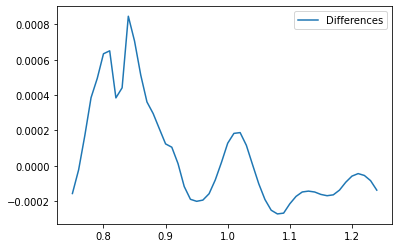

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_price(S):
    inputs = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T))

# plt.plot(prices, model_call_prices, label = "model_call_prices")
# plt.plot(prices, correct_call_prices, label = "JAX_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

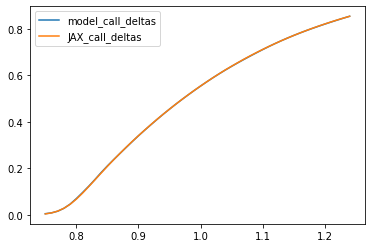

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.0, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

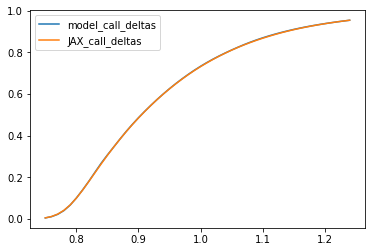

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 0.775, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

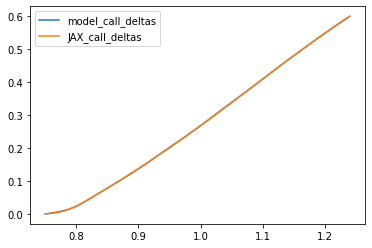

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.225, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.225, B, T))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

# Comparison on speed

In [ ]:
# time difference for computing delta
%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T)
%timeit compute_delta(1).item()

10 loops, best of 5: 415 ms per loop
The slowest run took 941.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 365 µs per loop


# Heat Map

In [5]:
import pandas as pd
import numpy as np
import cupy

df = pd.DataFrame(np.zeros((25,10)))
df.columns = np.around(np.linspace(0.005, 0.05, 10), 3)
df.index = np.around(np.arange(0.77, 1.27, 0.02), 2)

for col_num,approx_width in enumerate(df.columns):
  base = []
  approx = [] # approximated value calculated from base
  model_value = [] # value given by model
  for S in df.index:
    inputs = torch.tensor([[1, 1, 0.8, S - approx_width, 0.25, 0.02, 0.02]]).cuda()
    base.append(model(inputs.float())[0][0])
    approx.append(model(inputs.float())[0][0] + ((model(inputs.float())[0][1:]) * approx_width).sum())
    inputs2 = torch.tensor([[1, 1, 0.8, S, 0.25, 0.02, 0.02]]).cuda()
    model_value.append(model(inputs2.float())[0][0])
  abs_error = (np.absolute(np.array(approx)-np.array(model_value))).astype(float)
  df.iloc[:,col_num] = abs_error

df

,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050
0.77,0.000590,0.001057,0.001418,0.001707,0.001908,0.002024,0.002091,0.002117,0.002113,0.002087
0.79,0.001054,0.002033,0.002937,0.003748,0.004420,0.004947,0.005352,0.005670,0.005890,0.006019
0.81,0.001377,0.002767,0.004211,0.005545,0.006794,0.007939,0.008981,0.009904,0.010657,0.011246
0.83,0.001494,0.002946,0.004375,0.005870,0.007512,0.009159,0.010852,0.012412,0.013856,0.015167
0.85,0.001117,0.002455,0.004148,0.005951,0.007739,0.009474,0.011178,0.012944,0.014852,0.016755
0.87,0.000963,0.002015,0.003165,0.004420,0.005814,0.007441,0.009434,0.011540,0.013622,0.015641
0.89,0.000798,0.001726,0.002768,0.003915,0.005139,0.006454,0.007870,0.009396,0.011068,0.012983
0.91,0.000692,0.001478,0.002349,0.003299,0.004355,0.005540,0.006840,0.008246,0.009731,0.011310
0.93,0.000536,0.001142,0.001844,0.002660,0.003591,0.004620,0.005739,0.006942,0.008254,0.009696
0.95,0.000478,0.001013,0.001609,0.002306,0.003070,0.003907,0.004842,0.005894,0.007064,0.008336


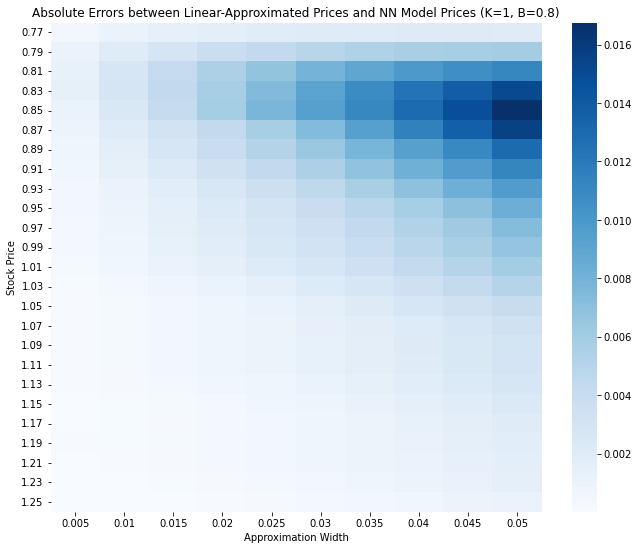

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(df, cmap='Blues')
plt.title('Absolute Errors between Linear-Approximated Prices and NN Model Prices (K=1, B=0.8)')
plt.xlabel('Approximation Width')
plt.ylabel('Stock Price')
plt.show()